For Project 3 in my **Intro to Cloud Computing** course, we were tasked with finding a problem that could be solved using a distributed platform (Spark, Hadoop / MapReduce) and then using a distributed platform to engage the problem. I chose to develop a model which identified spam text messagaes using Spark through Amazon Sagemaker and Amazon Web Services (AWS) platform. This post is going to walk through the process of developing this model and settting up all the necessary resources. To be specific is going to cover the following actions:

* Estanblish a **LOCAL** Spark Session. (Future posts may connect to a Spark Cluster on Amazon EMR
* Load text message data from Amazon S3 into Spark Session
* Process data with a Spark ML Pipeline
 * Develop customer transformers for the ML pipeline
* Train the resulting data on a SageMaker instance using SageMaker's XGBoost classification algorithm
* Deploy the trained SageMaker model
* Evalute the model performance by performing inference on the deployed endpoint

For complete access to the project files, the associated GitHub repo for this project can be found here: 

[https://github.com/canfielder/DSBA-6190_Proj3_Spark_w_Sagemaker](https://github.com/canfielder/DSBA-6190_Proj3_Spark_w_Sagemaker)

# Why SageMaker and Spark?
For this project we will be performing some standard Natural Language Processing (NLP) actions on SMS messages, and doing so using a distributed platform. Now, there are many different ways to develop a distributed platform process. If we want to use a Spark cluster we can go straight to the source and use Amazon EMR or Google Cloud Dataproc. Or we could set up a MapReduce job on Azure. 

So why bother tapping into SageMaker?

Keep in mind that a many Data Science / Machine Learning processes generally follow these overaching steps:

<p align ="middle">
  <img src="../imgs/data_science_process_flow.png" width="35%" />
</p>

We want to take special notices of steps two and three: **Process** and **Train**. Processing large quantities of text, and then training the resulting output of that process, might have wildly different sizing needs. If you do both on the same system you would have to size that system for the most conservative usage. This means one of these steps is going to be needlessly oversized (**$$$**).

Instead, we can de-couple the **Process** step from **Train** step by utilizing Spark and SageMaker togther. Instead of an oversized, single system, we can:

* **Process**: Run your NLP with Spark, either locally or on Amazon EMR clusters
* **Train**: Train your model on Amazon SageMaker instances 

Each process is dynamically sized and spec-ed (GPUs vs no GPUs, etc.) for the actual needs of just that process, not both. In addition, even though you are tapping in to multiple Amazon resources, it is simple to develop this architecture all within a SageMaker notebook.

**Note**: I want to recognize the following Medium post, [Mixing Spark with Sagemaker ?](https://medium.com/@julsimon/mixing-spark-with-sagemaker-d30d34ffaee7) for providing a good brief discussion on this very subject.

### Notes on Operating Environment
I am performing all following actions in Amazon SageMaker on a SageMaker instance. I initially tried to perform these actions locally, connecting to Amazon resources with Boto3. But I kept getting errors executing certain Pyspark actions which I couldn't resolve. Working directly in SageMaker did not result in any errors.

# Creating a Machine Learning Pipeline
In order to fully take advantage of using Spark and SageMaker, we're going to want to create a Spark ML Pipeline. By using a PipeLine, we can cleanly define a method that will perform all of the actions for both the **Process** and **Train** steps. This PipeLine will tap into Spark for the **Process** step, and SageMaker for the **Train** step. 

There are two main components for our ML Pipeline:

* Transformer
* Estimator

We will use Transformers for the **Process** step of the pipe. This will require using some readily available Transformers, but also creating some custom Transformers. These Transformer steps will use Spark resources. 

We will use an Estimator for the **Train** step of the pipeline. An estimator is algorithm that we will train using our data. For this project we will use the XGBoost estimator provided by SageMaker. The Estimator step wil use SageMaker resourses.

We can see the full documentation on pipelines here: [ML Pipelines](https://spark.apache.org/docs/latest/ml-pipeline.html).

# Spark Cluster
First up we will create a local SparkSession. We'll import the necessary libraries and modules, and then create the session.

In [73]:
import os
import boto3

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

import sagemaker_pyspark

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath)\
    .master("local[*]")\
    .appName("sms_spam_filter")\
    .getOrCreate()
    
spark

# AWS Settings and Connections
Wiht Spark initialized we need to make the right connections within AWS and define some of our parameters.

## Boto3 Connection
First things first, we're going to set up a connection to Amazon. Before we can do anything, if doing this work outside of Amazon SageMaker, make sure you have correctly set a AWS configuration file on whatever machine you are working on. See the following documentation for how to do this [Configuring the AWS CLI](https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html). 

I established a unique user and role for this exercise, which were granted the following permissions:

* AmazonS3FullAccess
* AmazonSageMakerFullAccess

**Note**: *These permissions are very broad. Usually, when granting permissions, follow the principle of [Grant Least Priviledge](https://docs.aws.amazon.com/IAM/latest/UserGuide/best-practices.html#grant-least-privilege).*


In [74]:
region = "us-east-1"
aws_credential_profile = 'blog_spam_sagemaker_spark'
role = 'blog_spam_sagemaker_spark'

With our region and AWS Credentials file profile defined, we can establish a connection to AWS via the SDK library Boto3. When working with Amazon SageMaker, I prefer establishing a *Session* at the start of my notebook, and then using the session to define Boto3 *Client* and *Resource* objects. This helps maintain a consistency when creating those objects.

In [75]:
import boto3

boto3_session = boto3.session.Session(region_name=region)

## AWS Role ARN
With a general session established, we are going to connect to the AWS IAM service and extract the ARN associated with role being used for this exercise. This ARN will be needed to access necessary resources AWS resources. The ARN could also be manually copied into this notebook, but I prefer using the Boto3 tools when available and not overly onerous.

In [76]:
# Establish IAM Client
client_iam = boto3_session.client('iam')

# Extract Avaiable Roles
role_list = client_iam.list_roles()['Roles']

# Initialized Role ARN variable and Establish Key Value
role_arn = ''
key = 'RoleName'

# Extract Role ARN for Exercise Role
for item in role_list:
    if key in item and role == item[key]:
        role_arn = item['Arn']

# Verify ARN
print(role_arn)

arn:aws:iam::726963482731:role/blog_spam_sagemaker_spark


# Import
The data for this project was the **SMS Spam Collection Dataset**, originally hosted on the UCI Machine Learning repository. The same dataset is also hosted on Kaggle, [here](https://www.kaggle.com/uciml/sms-spam-collection-dataset). I used the Kaggle API to load the data directly to our S3 bucket. More information on how to do that can be found on the [Kaggle GitHub page](https://github.com/Kaggle/kaggle-api) and in the main README file of my personal [GitHub page](https://github.com/canfielder/DSBA-6190_Proj3_Spark_w_Sagemaker) for this project. The result of following the necessary steps is the file *spam.csv*  in a S3 bucket, in this case named *dsba-6190-project3-spark*.

#### S3A Endpoint Check
The code in the following block comes directly from one of the [SageMaker Spark Examples on GitHub](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-spark/pyspark_mnist/pyspark_mnist_pca_kmeans.ipynb). I have added some additional commenting for context. Essentially this code checks to see if you region is in China, an applies the correct domain suffix to the S3A endpoint to reflect this. S3A is the connector between Haddop and AWS S3. 

For most regions this step is unnessecary as the default settings will be sufficient, but I have included it just to be safe.

In [77]:
# List of Chinese Regions
cn_regions = ['cn-north-1', 'cn-northwest-1']

# Current Region
region = boto3_session.region_name

# Defined Endpoint URL Domain Suffix (i.e.: .com)
endpoint_domain = 'com.cn' if region in cn_regions else 'com'

# Set S3A Endpoint
spark._jsc.hadoopConfiguration().set('fs.s3a.endpoint', 's3.{}.amazonaws.{}'.format(region, endpoint_domain))

## Load Data
The data we have is in CSV format. We're going to import this CSV into a pyspark DataFrame. Unlike using a Pandas dataframe, before we load the data it is recommended that we define a schema. For this data in particular, if a schema was not pre-defined, the resulting DataFrame would have contained empty columns.

In [78]:
from pyspark.sql.types import StructType, StructField, StringType

# Define S3 Labels
bucket = "dsba-6190-project3-spark"
file_name = "spam.csv"

# Define Known Schema
schema = StructType([
    StructField("class", StringType()),
    StructField("sms", StringType())
])

# Import CSV
df = spark.read\
          .schema(schema)\
          .option("header", "true")\
          .csv('s3a://{}/{}'.format(bucket, file_name))

## Inspect Data
After loading the data we're going to inspect the data to see what we're dealing with, and if there are any problems we need to sort through.

First, let's take a quick look at what our data looks like by inspecting the top 10 rows.

In [79]:
df.show(10, truncate = False)

+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|class|sms                                                                                                                                                             |
+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ham  |Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...                                                 |
|ham  |Ok lar... Joking wif u oni...                                                                                                                                   |
|spam |Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075o

So pretty straight forward. There are two columns. One column contains our target variable, **class**. The other column contains the raw SMS text, which we will need to process before training our model.

As this project is going to boil down to a binary classification exercise, let's look at the frequency counts for our target variable.

In [80]:
df.groupBy("class").count().show()

+------+-----+
| class|count|
+------+-----+
|ham"""|    2|
|   ham| 4825|
|  spam|  747|
+------+-----+



Uh oh! It appears two observations have errors in the target variable field, **ham"""**. Let's take a closer look at theses specific observations.

In [81]:
import pyspark.sql.functions as f

df.where(f.col("class") == 'ham"""').show(truncate = False)

+------+---------------------------------------------------------+
|class |sms                                                      |
+------+---------------------------------------------------------+
|ham"""|null                                                     |
|ham"""|Well there's still a bit left if you guys want to tonight|
+------+---------------------------------------------------------+



So, one row is null, while there other appears to be a standard **ham** message. Before doing anthing yet, let's see how many null values are in the complete dataset.

In [82]:
from functools import reduce

df.where(reduce(lambda x, y: x | y, (f.col(x).isNull() \
                                     for x in df.columns))).show()

+------+----+
| class| sms|
+------+----+
|ham"""|null|
+------+----+



It seems like there is only the one null value. So, we'll drop the null observation and then correct the typo in the target variable for the other observation. We'll check the target variable frequency again to make sure our corrections were implemented.

In [83]:
# Drop Null
df = df.dropna()

# Correct """ham to ham
df = df.withColumn("class", f.when(f.col("class") == 'ham"""' , 'ham').
                     otherwise(f.col("class")))

# Generate Target Frequency Count
df.groupBy("class").count().show()

+-----+-----+
|class|count|
+-----+-----+
|  ham| 4826|
| spam|  747|
+-----+-----+



## Split Data
We will need to split our data into Training and Validation sets. We will use the Training set to train our XGBoost model. We will then evaluate the trained model using the Validation set. We will use a 75/25 split.

**Note**: *Below I also define a seed value. This is used for steps that may return random values. By defining a seed, we that randomness which helps compare outputs and see what changes have what effects.

In [84]:
seed = 5590
split_ratio = 0.75
df_train, df_test = df.randomSplit([split_ratio, (1-split_ratio)], seed=seed)

# Process
Before the our data reaches the **Train** step of our pipeline, it needs to pass through the **Processing** step. As previously stated, **Processing** is going to requie Transformers. This is going to include pre-existing Natural Language Processing (NLP) Transformers, as well as several custom defined Transformers. 

The **Process** step can be broken out into the follow sub-steps. For each sub-step we will go through the required Transformers. 

1. Convert Target Variable to binary double-type 
2. Text Normalization
3. Tokenization 
4. Stop Workd Removal
5. TF-IDF Transformation

#### A Note on Custom Transformers
For custom Transformers, I recommend creating a separate python script defining them, and then loading this script into our notebook when needed. I defined my custom Transformers in a script named *custom_transformers.py* and located it in a the directory *scripts*, located a direct sub-directory to the main working directory of my project. 

For clarity I will include the code for defining the custom Transformers in this post, but take notice that in practice this code is located in the seperate script.

#### A Note on Final Data Format
At the end of the Process portion of the Pipeline, we need our DataFrame to be two columns. We need a column of *Doubles* named **label** (our tagret variable), and a column of *Vectors of Doubles* name **features** (our processed text). This is the format our SageMaker XGBoost estimator will understand.

## Process Step 1: Target Variable 
Currently our target variable is a string-type value labeled either spam or ham. We need to convert this to an double-type value of 1 and 0. For this we defined a custom Transformer, shown below. 

##### Custom Transformer: Binary Target Variable

In [85]:
# Insert Custom Transformer Text

## Process Step 2: Text Normalization
With Text Normalization, we will process the raw text to provide a quality input for our model. The actions used the blog post [**Spam classification using Spark’s DataFrames, ML and Zeppelin (Part 1)**](https://blog.codecentric.de/en/2016/06/spam-classification-using-sparks-dataframes-ml-zeppelin-part-1/) by Daniel Pape, accessed on 4/16/2020, were used as guidance. This blog post provided a good framework particularly for handling types of text you find in an SMS message, such as emoticons.

To normalize the text, there are nine steps we plan on taking:

1. Convert all text to lowercase
2. Convert all numbers to the text **_" normalized_number "_**
3. Convert all emoticons to the text **_" normalized_emoticon "_**
4. Convert all currency symbols to the text **_" normalized_currency_symbol "_**
5. Convert all links to the text **_" normalized_url "_**
6. Convert all email addresses to the text **_" normalized_email "_**
7. Convert all diamond/question mark symbols to the text **_" normalized_doamond_symbol "_**
8. Remove HTML characters
9. Remove punctuation

These 9 steps can be executed using two custom Transformers. The first will convert all text to lower case. 
##### Custom Transformer: Convert Text to Lower Case

In [86]:
# Insert Custom Transformer Text

The second custom Transformer will execute steps two through nine. The custom Transformer identifies text by a provided REGEX expression, and the replaces that identified text will a provided string. To execute steps two through nine, we will call this custom Transformer eight times, each time defining a new REGEX expression and repalcement string. 

##### Custom Transformer: Replace Text

In [87]:
# Insert Custom Transformer Text

To better organize the regex strings and normalized text associated with each point above, I saved each REGEX expression as a variable and, created a dictionary cataloging them.

In [88]:
# List of HTML text
html_list = ["&lt;", "&gt;", "&amp;", "&cent;", "&pound;", "&yen;", "&euro;", "&copy;", "&reg;"]

# Regex Expressions for normalizing text
regex_email = "\\w+(\\.|-)*\\w+@.*\\.(com|de|uk)"
regex_emoticon = ":\)|:-\)|:\(|:-\(|;\);-\)|:-O|8-|:P|:D|:\||:S|:\$|:@|8o\||\+o\(|\(H\)|\(C\)|\(\?\)"
regex_number = "\\d+"
regex_punctuation ="[\\.\\,\\:\\-\\!\\?\\n\\t,\\%\\#\\*\\|\\=\\(\\)\\\"\\>\\<\\/]"
regex_currency = "[\\$\\€\\£]"
regex_url =  "(http://|https://)?www\\.\\w+?\\.(de|com|co.uk)"
regex_diamond_question = "�"
regex_html = "|".join(html_list)

# Dictionary of Normalized Text and Regex Expressions
dict_norm = {
    regex_emoticon : " normalized_emoticon ",
    regex_email : " normalized_emailaddress ",
    regex_number : " normalized_number ",
    regex_punctuation : " ",
    regex_currency : " normalized_currency_symbol ",
    regex_url: " normalized_url ",
    regex_diamond_question : " normalized_doamond_symbol ",
    regex_html : " "
}

Finally, we create one more custom Transformer that selects the **label** and **features** column from our processed data. 

##### Custom Transformer: Select Columns

In [89]:
# Insert Custom Transformer Text

## Process Step 3: Tokenization
For this project we will be tokenizing the normalized SMS text with a Bag-of-Words approach. 

For this step we do not need to define a Transformer as the Pyspark package alread contains the **Tokenizer** Transformer.

## Process Step 4: Stop Word Removal
With the raw SMS tex tokenized, we can easily remove stop words. Stop words are common words (such as "the", "a", "and", etc.) that don't provide any additional information for our model. We will be using the default English stop words, but custom stop words can also be added. Custom stop words are particularly usefule if processing text all associated with a specific topic. 

For this step we do not need to define a Transformer as the Pyspark package alread contains the **StopWordsRemover** Transformer.

## Process Step 5: Term Frequency - Inverse Docuemnt Frequency Transformation
With our raw SMS text fully processes, we now transform our data into numerical form, using Term Frequency and Inverse Document Frequency tranformations. Term Frequency simply measures how frequent each term is in each document (in our case each SMS text message). Inverserse Document Frequecy provides a measurement for how important each term is, by incorporating a factor representing how often each term is used in a document at all. 

For this step we do not need to define a Transformer as the Pyspark package alread contains the **HashingTF** Transformer for Term Frequency, and the **IDF** Transformer for Inverse Document Frequency.

## Define Process PipeLine Stages
Now that we have gone over each Transformer, we need to initialize them before incorporating them into the pipeline. 

But first, we need to load our script of custom Transformers, so that the code in this notebook recognizes them.

In [90]:
%run '../scripts/custom_transformers.py'

With our custom Transformers loaded, we can initialize all of our **Process** step Transformers.

In [91]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF

# Define Output column name
output_col = 'features'

# Process Step 1: Target Variable 
stage_binary_target=BinaryTransform(inputCol="class")

# Process Step 2: Text Normalization
stage_lowercase_text=LowerCase(inputCol= "sms", outputCol=output_col)

stage_norm_emot=NormalizeText(inputCol=stage_lowercase_text.getOutputCol(), 
                               outputCol=output_col, 
                               normal_text=dict_norm[regex_emoticon],
                               regex_replace_string=regex_emoticon)

stage_norm_email=NormalizeText(inputCol=stage_norm_emot.getOutputCol(), 
                               outputCol=output_col, 
                               normal_text=dict_norm[regex_email],
                               regex_replace_string=regex_email)

stage_norm_num=NormalizeText(inputCol=stage_norm_email.getOutputCol(), 
                               outputCol=output_col, 
                               normal_text=dict_norm[regex_number],
                               regex_replace_string=regex_number)

stage_norm_punct=NormalizeText(inputCol=stage_norm_num.getOutputCol(), 
                               outputCol=output_col, 
                               normal_text=dict_norm[regex_punctuation],
                               regex_replace_string=regex_punctuation)

stage_norm_cur=NormalizeText(inputCol=stage_norm_punct.getOutputCol(), 
                               outputCol=output_col, 
                               normal_text=dict_norm[regex_currency],
                               regex_replace_string=regex_currency)

stage_norm_url=NormalizeText(inputCol=stage_norm_cur.getOutputCol(), 
                               outputCol=output_col, 
                               normal_text=dict_norm[regex_url],
                               regex_replace_string=regex_url)

stage_norm_diamond=NormalizeText(inputCol=stage_norm_url.getOutputCol(), 
                               outputCol=output_col, 
                               normal_text=dict_norm[regex_diamond_question],
                               regex_replace_string=regex_diamond_question)

# Process Step 3: Tokenization
tokens = Tokenizer(inputCol=output_col, outputCol='tokens')

# Process Step 4: Stop Word Removal
stop_words = StopWordsRemover(inputCol=tokens.getOutputCol(), 
                           outputCol="tokens_filtered")

# Process Step 5: Term Frequency - Inverse Docuemnt Frequency Transformation
# Term Frequency Hash
hashingTF = HashingTF(inputCol=stop_words.getOutputCol(),
                      outputCol="tokens_hashed", numFeatures=1000)

# IDF 
idf = IDF(minDocFreq=2, inputCol=hashingTF.getOutputCol(), 
          outputCol="features_tfidf")

# Final Processing Step - Column Selection 
stage_column_select=ColumnSelect(inputCol=idf.getOutputCol())

# Train
With our data processed we can now use it to train our model. As stated previously we are going to use the SageMaker XGBoost algorithm.

## Parameters
The following code defines the parameters and initializes the XGBoost Estimator for use in our pipeline. 

A few notes: 

* One very important part of initializing this Estimator is the **requestRowSerializer** parameter. The preferred data format for the SageMaker XGBoost Estimator is LibSVM. But our data was imported as CSV. Therefore, we need to call the **requestRowSerializer** parameter and use the **LibSVMRequestRowSerializer** fucntion. Without this parameter we would get an error. Our Estimator would not know how to read our data. Also note that we also need to define a schema when using the **LibSVMRequestRowSerializer**.

* I recommend including a prefix for the Training Job name. This is done below in the **namePolicyFactory** parameter. Adding a prefix to our Training Job name makes it easier to find the job later.

* We used **CREATE_ON_TRANSFORM** for our **endpointCreationPolicy**. This means the inference endpoint will only be created when we try to transform our data with the endpoint. 


In [92]:
from pyspark.ml.linalg import VectorUDT
from sagemaker_pyspark import RandomNamePolicyFactory, IAMRole, \
    EndpointCreationPolicy
from sagemaker_pyspark.algorithms import XGBoostSageMakerEstimator
from sagemaker_pyspark.transformation.serializers.serializers \
    import LibSVMRequestRowSerializer

# Define Schema
schema_estimator = StructType([
    StructField("label", DoubleType()),
    StructField("features", VectorUDT())
])

# Initialize XGBoost Estimator
xgboost_estimator = XGBoostSageMakerEstimator(
    sagemakerRole = IAMRole(role_arn),
    requestRowSerializer=LibSVMRequestRowSerializer(schema=schema_estimator,
                                                 featuresColumnName="features",
                                                 labelColumnName="label"),
    trainingInstanceType = "ml.m4.xlarge",
    trainingInstanceCount = 1,
    endpointInstanceType = "ml.m4.xlarge",
    endpointInitialInstanceCount = 1,
    namePolicyFactory=RandomNamePolicyFactory("spam-xgb-"),
    endpointCreationPolicy = EndpointCreationPolicy.CREATE_ON_TRANSFORM
)

## Hyperparameters
Wiht our Estimator inialized we can define hyperparameters. Hyperparameters are the parameters which are not required for the model to run, and that can be arbitrarily set by the user before training.

* Well arbitrarily set the number of rounds to 15. This is just to save time and money. A more accurate model may need to run for a longer period.
* This problem is a binary classification problem, so we'll et the objective to **binary:logistic** and evaluate based on the **AUC** score.
* Well set the seed to make it easier to compare results.

In [93]:
xgboost_estimator.setNumRound(15)
xgboost_estimator.setObjective("binary:logistic")
xgboost_estimator.setEvalMetric("auc")
xgboost_estimator.setSeed(seed)

# Pipeline

With all of the Transformers and Estimators initilized, we now initilze our pipeline. Note that the order each Transformer is listed in the pipeline is the order in which the action occurs.

In [94]:
from pyspark.ml import Pipeline

pipeline=Pipeline(stages=[stage_binary_target, stage_lowercase_text, 
                          stage_norm_emot, stage_norm_url, stage_norm_num,
                          stage_norm_punct, stage_norm_cur, stage_norm_url,
                          stage_norm_diamond, tokens, stop_words, hashingTF,
                          idf, stage_column_select, xgboost_estimator]
                 )

We then fit the pipeline with our training dataset.

In [95]:
model = pipeline.fit(df_train)

With our pipeline trained, we can then generate predictions.

In [96]:
prediction = model.transform(df_test)
prediction.show(5)

+-----+--------------------+---------------+
|label|            features|     prediction|
+-----+--------------------+---------------+
|  0.0|(1000,[73,183,301...|0.0678308457136|
|  0.0|(1000,[51,134,164...| 0.569287598133|
|  0.0|(1000,[19,104,150...| 0.143226265907|
|  0.0|(1000,[24,29,62,6...| 0.206150710583|
|  0.0|(1000,[94,127,235...|0.0886066406965|
+-----+--------------------+---------------+
only showing top 5 rows



# Evaluate
Now that we generated predicted values, we can evaluate the performance of our model. First we need to define which observation was **spam**, and which was **ham**. We currently only have probabilies that each observation is **spam**. Therefore, we define the probability threshold as 0.5 and label each prediction as either **spam** or **ham**. We also similarly re-label the **label** column to **spam** and **ham** in order to compare against the predicted values.

In [97]:
prediction = prediction.withColumn("prediction_binary", \
                                     f.when(f.col("prediction") > 0.5 , 1.0).
                                     otherwise(0.0))

prediction = prediction.withColumn("prediction_spam", \
                                     f.when(f.col("prediction_binary") == 1 ,\
                                            "spam").otherwise("ham"))

prediction = prediction.withColumn("label_spam",\
                                     f.when(f.col("label") == 1 , "spam").
                                     otherwise("ham"))
prediction.show(5)

+-----+--------------------+---------------+-----------------+---------------+----------+
|label|            features|     prediction|prediction_binary|prediction_spam|label_spam|
+-----+--------------------+---------------+-----------------+---------------+----------+
|  0.0|(1000,[73,183,301...|0.0678308457136|              0.0|            ham|       ham|
|  0.0|(1000,[51,134,164...| 0.569287598133|              1.0|           spam|       ham|
|  0.0|(1000,[19,104,150...| 0.143226265907|              0.0|            ham|       ham|
|  0.0|(1000,[24,29,62,6...| 0.206150710583|              0.0|            ham|       ham|
|  0.0|(1000,[94,127,235...|0.0886066406965|              0.0|            ham|       ham|
+-----+--------------------+---------------+-----------------+---------------+----------+
only showing top 5 rows



## Classification Scores
Now we can look at some of the classification scores. Note that we are using both the **MulticlassClassificationEvaluator** and **BinaryClassificationEvaluator** objects to generate the metrics we want. 

In [98]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,\
                                  BinaryClassificationEvaluator

def output_scores(prediction):
    digit_format  = ": {:.4f}"
    
    ### Multi-Class Evaluator
    dict_metric_multi = {"Accuracy" : "accuracy", 
                         "Precision - Weighted" : "weightedPrecision", 
                         "Recall - Weighted" : "weightedRecall",
                         "F1 Score": "f1"}

    for key, value in dict_metric_multi.items():
        evaluator =  MulticlassClassificationEvaluator(labelCol="label", 
                                                   predictionCol=\
                                                       "prediction_binary", 
                                                   metricName=value)

        metric = evaluator.evaluate(prediction)

        print(key + digit_format.format(metric))   
    
    # Binary Class Evaluator
    dict_metric_bin = {"AUC Score" : "areaUnderROC"}
    for key, value in dict_metric_bin.items():
    
        evaluator=BinaryClassificationEvaluator(rawPredictionCol="prediction",
                                                  labelCol="label", 
                                                  metricName=value)
        
        metric = evaluator.evaluate(prediction)
        print(key + digit_format.format(metric))

In [99]:
output_scores(prediction)

Accuracy: 0.9746
Precision - Weighted: 0.9742
Recall - Weighted: 0.9746
F1 Score: 0.9741
AUC Score: 0.9783


## ROC Curve
Another good classification metric is a Receiver Under the Curve (ROC) plot. Unfortunatley, the pyspark library does not have the functions to generate this plot. So we'll need to convert our prediction Spark DataFrame to a Pandas dataframe. Once converted we can calculate the necessary metrics and plot the ROC Curve.
### Metrics

In [101]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Observed Target
test_label = prediction.select('label').toPandas()

# Predicted Target
test_pred = prediction.select('prediction').toPandas()

# ROC Curve Metrics
fpr, tpr, thresholds = roc_curve(test_label, test_pred)

# Area Under the Curv
roc_auc = auc(fpr, tpr)

### Plot

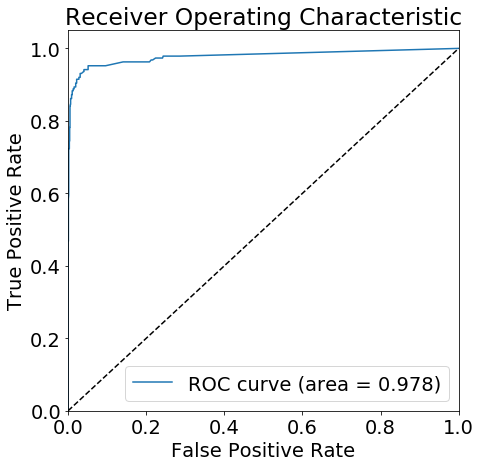

In [102]:
plt.rc('font', size=19.5) 
plt.figure(figsize=[7,7])
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## Confusion Matrix
Finally, we want to look at a Confusion Matrix to better visualize how well our model predicted **spam** SMS text messages. Much like the ROC curve, first we need to calculate some required metrics. Then we can plot the matrix.

### Metrics
First, we generate a list of class names. 

In [103]:
# Create List of Class Names
class_label = prediction.select("label_spam").groupBy("label_spam")\
    .count().sort('count', ascending=False).toPandas()
class_names = class_label["label_spam"].to_list()

Then we calculate the raw Confusion Matrix.

In [104]:
from sklearn.metrics import confusion_matrix

# Convert Labels to Pandas Dataframe
y_true = prediction.select("label_spam")
y_true = y_true.toPandas()

# Convert Predictions to Pandas Dataframe
y_pred = prediction.select("prediction_spam")
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_true, y_pred, labels=class_names)

### Plot
With our raw Confusion Matrix calculated, we can generate a plot.

In [105]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print()
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

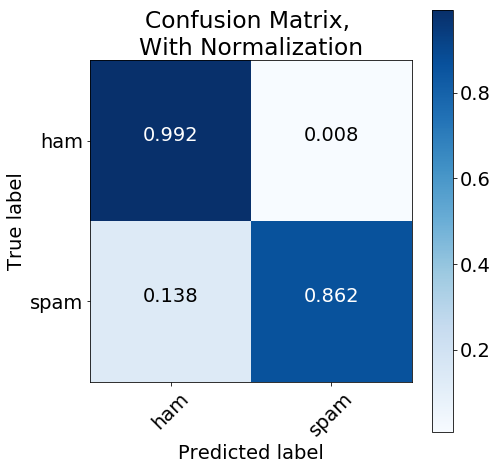

In [106]:
import numpy as np
import itertools

plt.figure(figsize=[7,7])
plot_confusion_matrix(cm, 
                      classes=class_names,
                      normalize=True,
                      title='Confusion Matrix, \nWith Normalization')
plt.show()

# Clean Up
Once this effort is completed we'll want to delete our endpoint to avoid unnecessary costs.

In [107]:
from sagemaker_pyspark import SageMakerResourceCleanup
from sagemaker_pyspark import SageMakerModel

def cleanUp(model):
    resource_cleanup = SageMakerResourceCleanup(model.sagemakerClient)
    resource_cleanup.deleteResources(model.getCreatedResources())
    
# Delete the SageMakerModel in pipeline
for m in model.stages:
    if isinstance(m, SageMakerModel):
        cleanUp(m)